# Feature Engineering for Churn Detection

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table, plot_pie
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.evaluation import display_clf_report, validate_model_with_cv
from churn_detection.features import ColumnPreprocessor, Transformation, engineer_features, create_pipe


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

## Feature Engineering Strategies

### Interaction Features

**Category Concatenation**:<br>
Let's concatenate two categorical features into a single categorical feature that represents all unique combinations of these two.<br>
This kind of strategy can lead to coincidental patterns, but it's a good idea to test it because it's easy to implement.

In [4]:
# Example with multiplelines and paymentmethod
cat_var_1 = "multiplelines"
cat_var_2 = "paymentmethod"
new_feature = f"{cat_var_1}_{cat_var_2}_concat"

new_preprocessed_data = preprocessed_data.copy()
new_preprocessed_data[new_feature] = new_preprocessed_data[cat_var_1] + "_" + new_preprocessed_data[cat_var_2]

In [5]:
new_preprocessed_data.head().T.tail()

,0,1,2,3,4
paymentmethod,electronic_check,mailed_check,mailed_check,bank_transfer_(automatic),electronic_check
monthlycharges,29.85,56.95,53.85,42.3,70.7
totalcharges,29.85,1889.5,108.15,1840.75,151.65
churn,0,0,1,0,1
multiplelines_paymentmethod_concat,no_phone_service_electronic_check,no_mailed_check,no_mailed_check,no_phone_service_bank_transfer_(auto...,no_electronic_check


Let's visualize this feature.

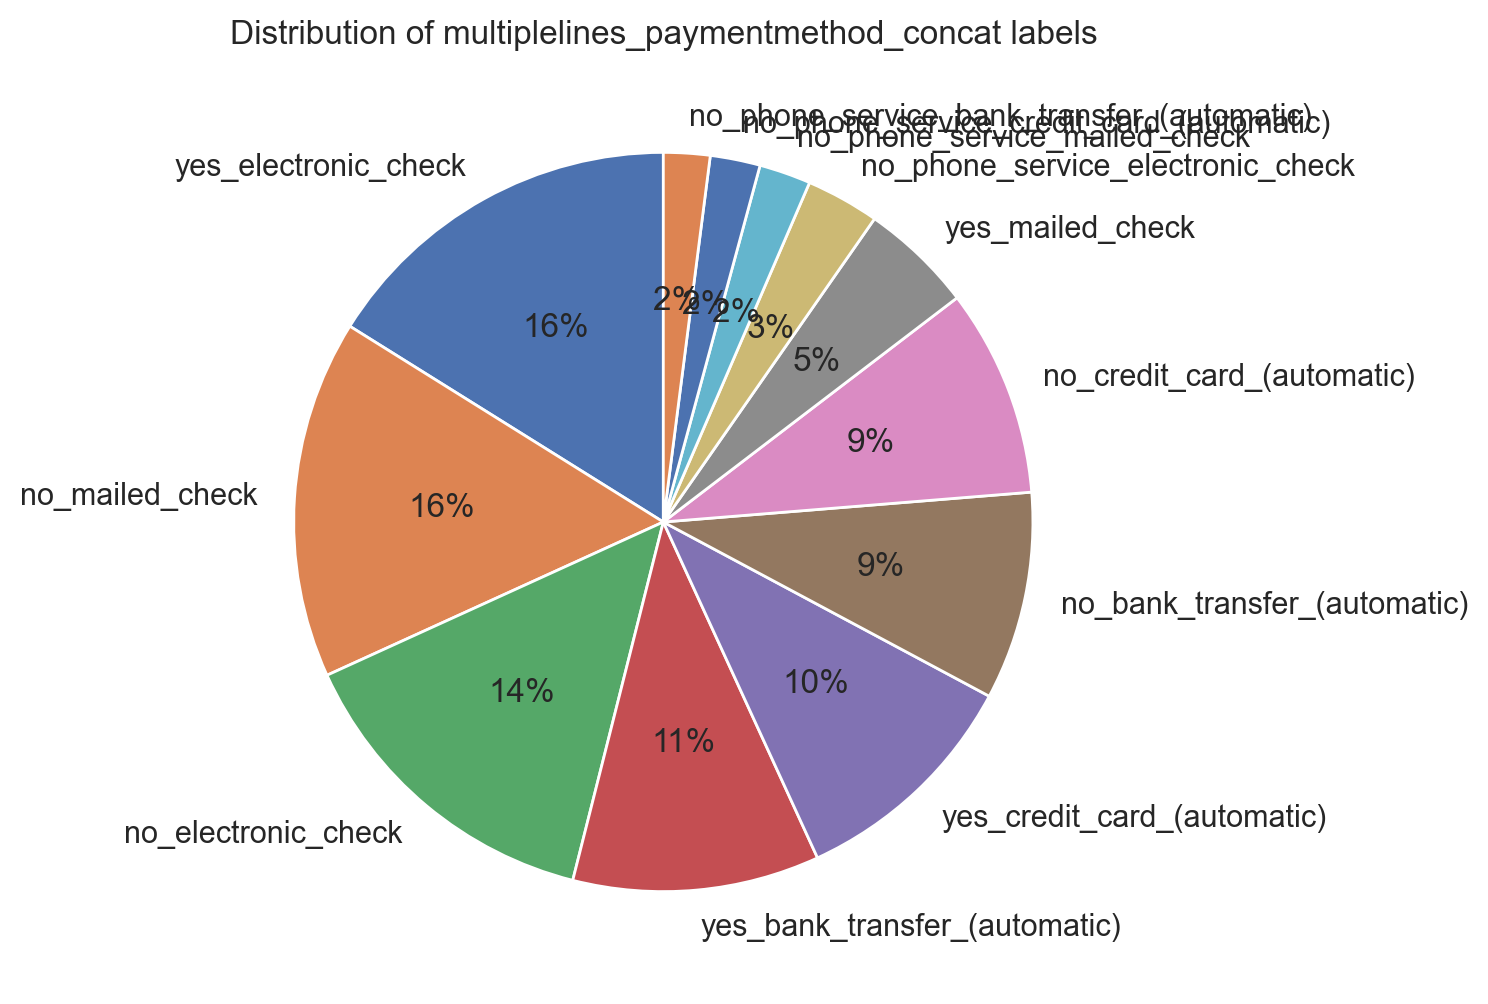

In [6]:
plot_pie(new_preprocessed_data, new_feature)

## Model Training and Testing

In [7]:
multimodal_set = numeric_variables[:-1] 
skewed_set = ["totalcharges"] 

In [8]:
MULTIMODAL_FEATURES = {
    "name": "multimod", "variables": multimodal_set,
    "steps": [("stdscaler", StandardScaler())],
}

SKEWED_FEATURES = {
    "name": "skewed", "variables": skewed_set,
    "steps": [("robustscaler", RobustScaler(quantile_range=(40, 60)))],
}

discrete_vars_pairs = list(combinations(categorical_variables, 2))
for cat_var_1, cat_var_2 in discrete_vars_pairs:
    new_feature = f"{cat_var_1}_{cat_var_2}_concat"
    
    new_preprocessed_data = preprocessed_data.copy()
    new_preprocessed_data[categorical_variables] = new_preprocessed_data[categorical_variables].astype("str")
    new_preprocessed_data[new_feature] = new_preprocessed_data[cat_var_1] + "_" + new_preprocessed_data[cat_var_2]
    
    discrete_set = categorical_variables + [new_feature]
    DISCRETE_FEATURES = {
        "name": "discrete", "variables": discrete_set,
        "steps": [("catencoder", OneHotEncoder(drop="if_binary", sparse_output=False))],
    }
    
    pipeline = ColumnPreprocessor()
    pipeline.add_transformation(
        Transformation(**MULTIMODAL_FEATURES)
    )
    pipeline.add_transformation(
        Transformation(**SKEWED_FEATURES)
    )
    pipeline.add_transformation(
        Transformation(**DISCRETE_FEATURES)
    )

    prep_train, _ = train_test_split(
        new_preprocessed_data, 
        test_size=0.2, 
        random_state=1
    )

    lr_pipe = create_pipe(
        pipeline.create_preprocessor(), 
        LogisticRegression(random_state=0)
    )
    X_train, y_train = split_data(prep_train)
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_train)
    score = recall_score(y_pred, y_train, pos_label=1, average="binary")
    if score >= 0.67:
        print(f"{cat_var_1}_{cat_var_2}, {score}")

gender_onlinesecurity, 0.6703210649960846
internetservice_streamingtv, 0.6703383162863886
onlinesecurity_streamingtv, 0.672386895475819
techsupport_paymentmethod, 0.6706349206349206


### Final Pipeline Setting

In [9]:
cat_var_1 = "onlinesecurity"
cat_var_2 = "streamingtv"

new_preprocessed_data = preprocessed_data.copy()
new_preprocessed_data[f"{cat_var_1}_{cat_var_2}_concat"] = new_preprocessed_data[cat_var_1] + "_" + new_preprocessed_data[cat_var_2]

In [10]:
new_feature = new_preprocessed_data.iloc[:,-1].name
discrete_set = categorical_variables + [new_feature]
DISCRETE_FEATURES = {
    "name": "discrete", "variables": discrete_set,
    "steps": [("catencoder", OneHotEncoder(drop="if_binary", sparse_output=False))],
}

In [11]:
prep_train, prep_test = train_test_split(
    new_preprocessed_data, 
    test_size=0.2, 
    random_state=1
)

pipeline = ColumnPreprocessor()
pipeline.add_transformation(
    Transformation(**MULTIMODAL_FEATURES)
)
pipeline.add_transformation(
    Transformation(**SKEWED_FEATURES)
)
pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)

prep_train, prep_test = train_test_split(
    new_preprocessed_data, 
    test_size=0.2, 
    random_state=1
)
X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [12]:
model = LogisticRegression(random_state=0)
transformers = pipeline.get_transformations()
train_features = engineer_features(X_train, transformers)
model.fit(train_features, y_train)

LogisticRegression(random_state=0)

### Final Score on Test Data

In [13]:
# Test Data
test_features = engineer_features(X_test, transformers)
test_predictions = model.predict(test_features)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1061
           1       0.62      0.60      0.61       348

    accuracy                           0.81      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.81      0.81      0.81      1409



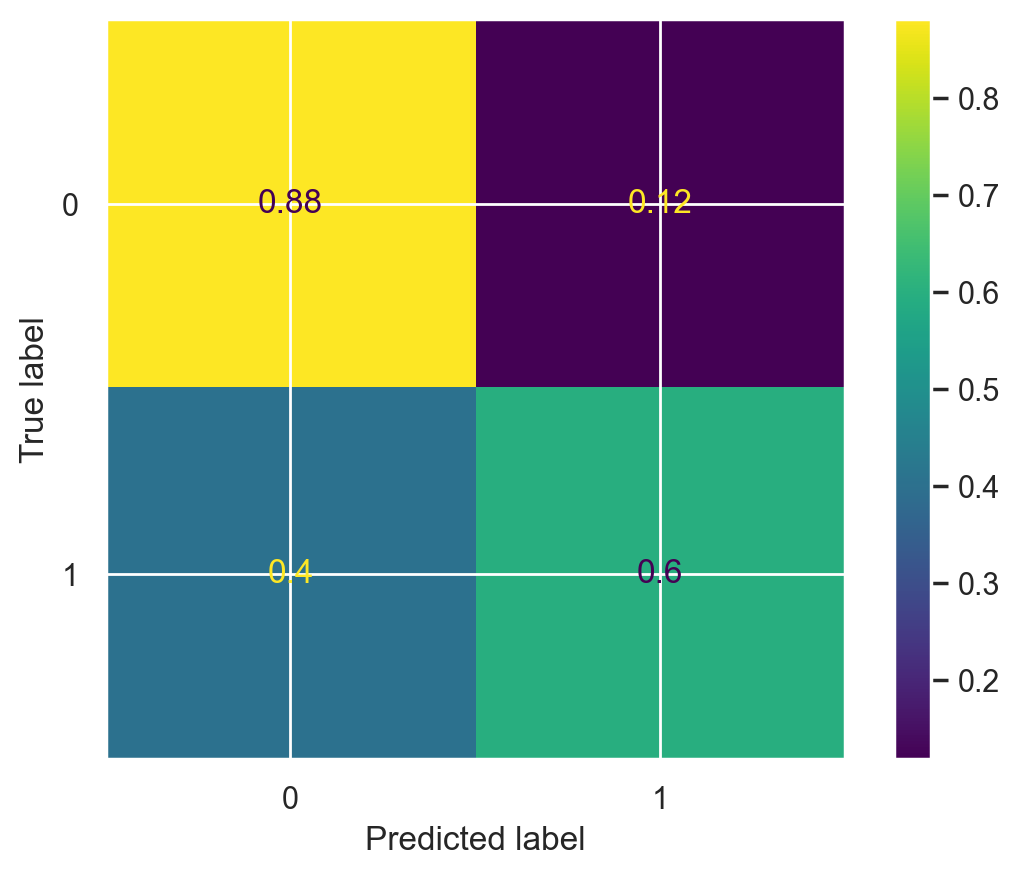

In [14]:
# Test Errors
plot_confusion_table(y_test, test_predictions)

This settings is equivalent in performance to logistic regression v5. Even in exploring all possible combinations of features. <br>
It could be interesting to refactor this procedure to be able to combine it later with other tweaking strategies.